In [1]:
import copy
import os
import time
import sqlalchemy
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from dotenv import load_dotenv

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel

from cities.modeling.zoning_models.zoning_tracts_continuous_interactions_model import TractsModelContinuousInteractions
from cities.utils.data_loader import select_from_data, ZoningDataset
from cities.modeling.waic import compute_waic

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

from cities.modeling.svi_inference import run_svi_inference
from cities.modeling.zoning_models.zoning_tracts_model import TractsModel
from cities.utils.data_loader import select_from_sql


root = find_repo_root()

In [2]:
census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path, weights_only=False)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract"],
    "continuous": {
        "housing_units",
        "total_value",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        "segregation_original",
        "white_original",
        "parcel_sqm",
        'downtown_overlap', 
        'university_overlap',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

In [3]:
# # direct db access won't work on CI setting
# # as the credentials are not available

# load_dotenv()
# load_dotenv(os.path.expanduser("~/.env_pw"))

# DB_USERNAME = os.getenv("DB_USERNAME")
# HOST = os.getenv("HOST")
# DATABASE = os.getenv("DATABASE")
# PASSWORD = os.getenv("PASSWORD")

# print(DB_USERNAME, HOST, DATABASE, PASSWORD)


# load_start = time.time()
# with sqlalchemy.create_engine(
#     f"postgresql://{DB_USERNAME}:{PASSWORD}@{HOST}/{DATABASE}"
# ).connect() as conn:
#     subset = select_from_sql(
#         "select * from dev.tracts_model__census_tracts order by census_tract, year",
#         conn,
#         kwargs,
#     )
# load_end = time.time()
# print(f"Data loaded in {load_end - load_start} seconds")

In [27]:
outs = [
    ("white", "limit"),
    ("sqm", "downtown_overlap"), 
    ("income", "segregation"),
    ("median_value", "income"),
]

ins = [
    ("university_overlap", "limit"),
    ("downtown_overlap", "limit"),
    ("distance", "downtown_overlap"),
    ("distance", "university_overlap"),
    ("distance", "limit"),
    # first stage additions, len 31
    ('median_value', 'segregation'),
    ('distance', 'segregation'),
    ('limit', 'sqm'),
    ('segregation', 'sqm')
]


hu_parent_names = [
            "median_value",
            "distance",
            "income",
            "white",
            "limit",
            "segregation",
            "sqm",
            "downtown_overlap",
            "university_overlap",
        ]


all_pairs = [(name1,name2) for name1 in hu_parent_names for name2 in hu_parent_names ] # name1 != name2]

print(len(all_pairs))
# drop pairs from outs from all_pairs
living_pairs = [pair for pair in all_pairs if pair not in outs]

print(len(living_pairs))

living_pairs = [pair for pair in living_pairs if pair not in ins]

print(len(living_pairs))

living_pairs = [
    (x, y) for (x, y) in living_pairs
    if x < y 
]

print(len(living_pairs))



81
77
68
27


[iteration 0001] loss: 11957.3193
[iteration 0050] loss: 11878.2656
[iteration 0100] loss: 11940.9824
[iteration 0150] loss: 11923.0693
[iteration 0200] loss: 11877.4932
[iteration 0250] loss: 11928.0684
[iteration 0300] loss: 11933.0947
[iteration 0350] loss: 11917.5479
[iteration 0400] loss: 11890.0322
[iteration 0450] loss: 11890.2236
[iteration 0500] loss: 11961.8164
[iteration 0550] loss: 11897.2646
[iteration 0600] loss: 11938.3428
[iteration 0650] loss: 11941.0723
[iteration 0700] loss: 11876.7793
[iteration 0750] loss: 11929.0723
[iteration 0800] loss: 11958.9404


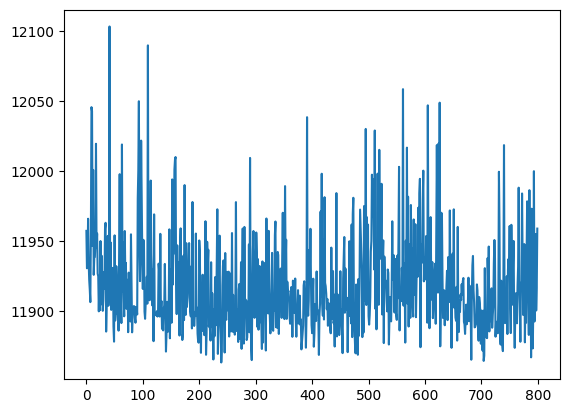

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11922.5439
[iteration 0050] loss: 11971.0361
[iteration 0100] loss: 11876.4639
[iteration 0150] loss: 11870.8965
[iteration 0200] loss: 11869.5225
[iteration 0250] loss: 11945.0918
[iteration 0300] loss: 11937.2646
[iteration 0350] loss: 11902.9170
[iteration 0400] loss: 11931.6104
[iteration 0450] loss: 11896.1172
[iteration 0500] loss: 11903.2363
[iteration 0550] loss: 11909.8369
[iteration 0600] loss: 11910.5840
[iteration 0650] loss: 11937.3027
[iteration 0700] loss: 12140.1885
[iteration 0750] loss: 11901.0146
[iteration 0800] loss: 11943.9443


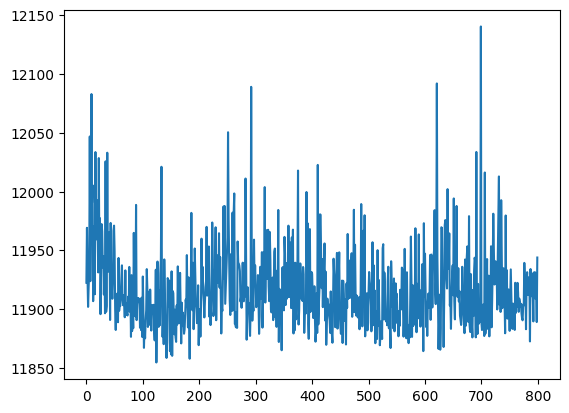

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 12025.9082
[iteration 0050] loss: 11942.2480
[iteration 0100] loss: 11921.0273
[iteration 0150] loss: 11883.5127
[iteration 0200] loss: 11921.3896
[iteration 0250] loss: 11974.2764
[iteration 0300] loss: 11889.8467
[iteration 0350] loss: 11909.6709
[iteration 0400] loss: 11877.3652
[iteration 0450] loss: 11963.8350
[iteration 0500] loss: 11913.8594
[iteration 0550] loss: 11905.6299
[iteration 0600] loss: 11897.7100
[iteration 0650] loss: 11902.6885
[iteration 0700] loss: 11893.6982
[iteration 0750] loss: 11894.3193
[iteration 0800] loss: 11899.1924


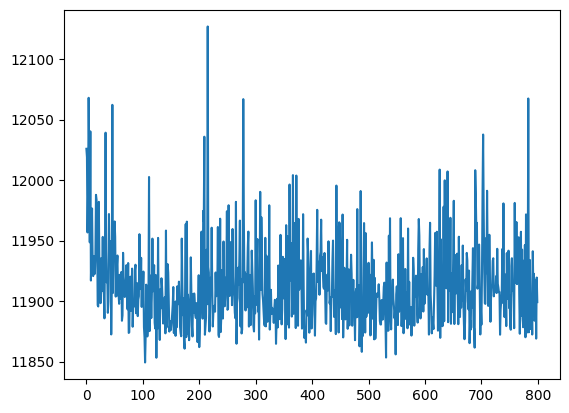

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11929.7217
[iteration 0050] loss: 11914.3379
[iteration 0100] loss: 11915.7930
[iteration 0150] loss: 11904.3086
[iteration 0200] loss: 11876.3477
[iteration 0250] loss: 11884.5898
[iteration 0300] loss: 11915.2617
[iteration 0350] loss: 11912.7539
[iteration 0400] loss: 11892.4521
[iteration 0450] loss: 11881.1377
[iteration 0500] loss: 12026.9521
[iteration 0550] loss: 11906.3789
[iteration 0600] loss: 11882.4482
[iteration 0650] loss: 11980.4463
[iteration 0700] loss: 11951.5166
[iteration 0750] loss: 11886.8330
[iteration 0800] loss: 11883.4473


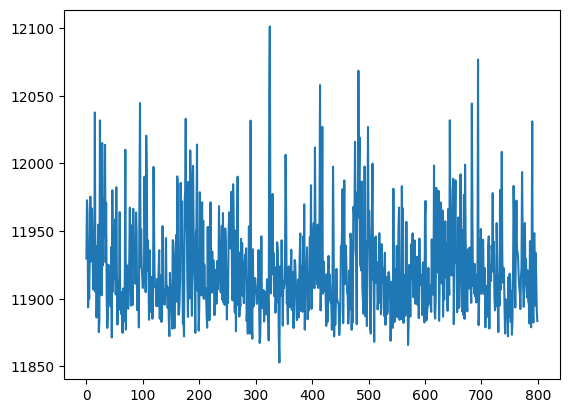

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11879.4609
[iteration 0050] loss: 11896.0977
[iteration 0100] loss: 11932.2676
[iteration 0150] loss: 11899.7334
[iteration 0200] loss: 11954.5068
[iteration 0250] loss: 11908.8457
[iteration 0300] loss: 11913.3164
[iteration 0350] loss: 12070.0391
[iteration 0400] loss: 11932.8066
[iteration 0450] loss: 11926.4619
[iteration 0500] loss: 11925.8809
[iteration 0550] loss: 11909.4434
[iteration 0600] loss: 11999.0723
[iteration 0650] loss: 11915.5664
[iteration 0700] loss: 11906.8047
[iteration 0750] loss: 12038.2559
[iteration 0800] loss: 11904.1924


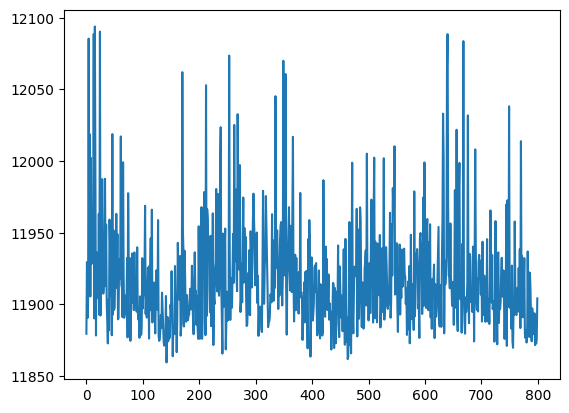

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11890.9170
[iteration 0050] loss: 11931.0645
[iteration 0100] loss: 11901.0410
[iteration 0150] loss: 11868.1689
[iteration 0200] loss: 11911.0381
[iteration 0250] loss: 11923.2432
[iteration 0300] loss: 11956.6836
[iteration 0350] loss: 11888.9316
[iteration 0400] loss: 11928.2812
[iteration 0450] loss: 11942.3018
[iteration 0500] loss: 11884.8984
[iteration 0550] loss: 11919.6826
[iteration 0600] loss: 11930.3076
[iteration 0650] loss: 11904.2754
[iteration 0700] loss: 11928.2275
[iteration 0750] loss: 11939.3145
[iteration 0800] loss: 11919.7832


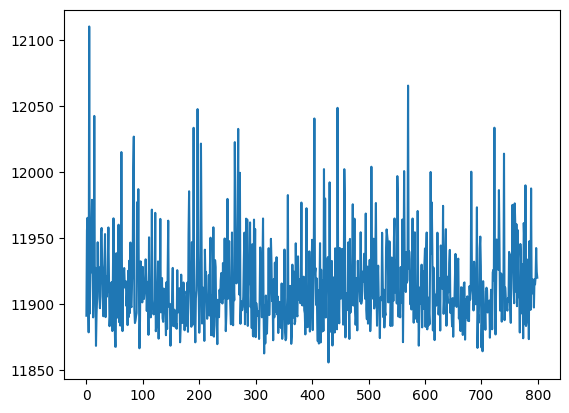

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11884.1602
[iteration 0050] loss: 11874.2539
[iteration 0100] loss: 11891.5898
[iteration 0150] loss: 11917.1250
[iteration 0200] loss: 11905.6104
[iteration 0250] loss: 11913.4629
[iteration 0300] loss: 11944.4229
[iteration 0350] loss: 11967.5693
[iteration 0400] loss: 11911.5957
[iteration 0450] loss: 11876.8105
[iteration 0500] loss: 11868.7754
[iteration 0550] loss: 11895.6680
[iteration 0600] loss: 11953.2217
[iteration 0650] loss: 11918.9502
[iteration 0700] loss: 11914.7920
[iteration 0750] loss: 11891.8506
[iteration 0800] l

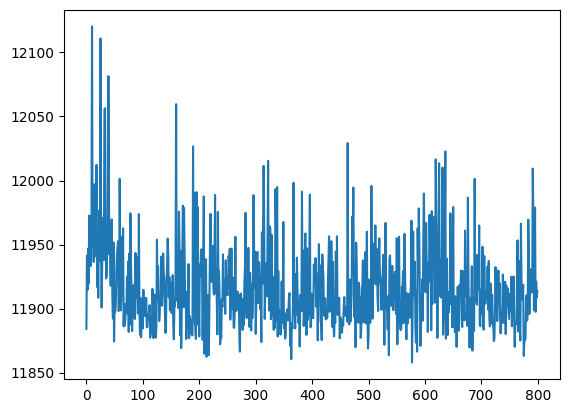

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11973.6689
[iteration 0050] loss: 11913.9736
[iteration 0100] loss: 11884.0820
[iteration 0150] loss: 11862.8174
[iteration 0200] loss: 11889.3750
[iteration 0250] loss: 11961.5068
[iteration 0300] loss: 11916.3662
[iteration 0350] loss: 11895.5078
[iteration 0400] loss: 11903.1543
[iteration 0450] loss: 11885.7578
[iteration 0500] loss: 11882.5547
[iteration 0550] loss: 11924.1426
[iteration 0600] loss: 11933.5869
[iteration 0650] loss: 11899.2695
[iteration 0700] los

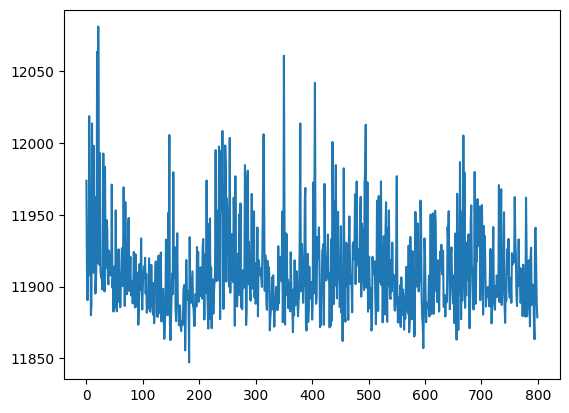

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 12159.1182
[iteration 0050] loss: 11898.7949
[iteration 0100] loss: 11886.2158
[iteration 0150] loss: 11865.0664
[iteration 0200] loss: 12008.3799
[iteration 0250] loss: 11931.9688
[iteration 0300] loss: 11937.4014
[iteration 0350] loss: 11906.9014
[iteration 0400] loss: 11902.9570
[iteration 0450] loss: 11941.8916
[iteration 0500] loss: 11876.1396
[iteration 0550] loss: 11872.4766
[iteration 0600]

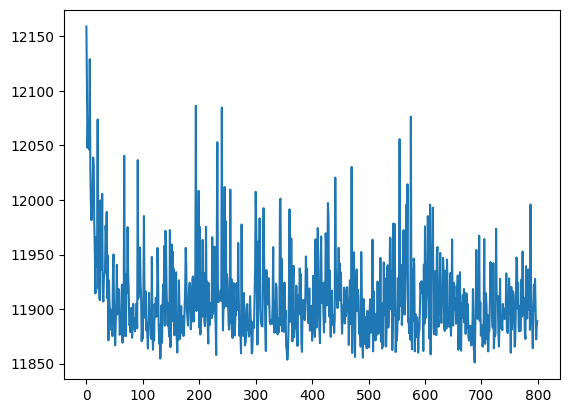

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11958.2393
[iteration 0050] loss: 11944.0850
[iteration 0100] loss: 11924.4551
[iteration 0150] loss: 11869.7607
[iteration 0200] loss: 11897.9648
[iteration 0250] loss: 11893.2480
[iteration 0300] loss: 11866.5732
[iteration 0350] loss: 11897.8135
[iteration 0400] loss: 11953.3037
[iteration 0450] loss: 11892.4658
[iteration 0500] los

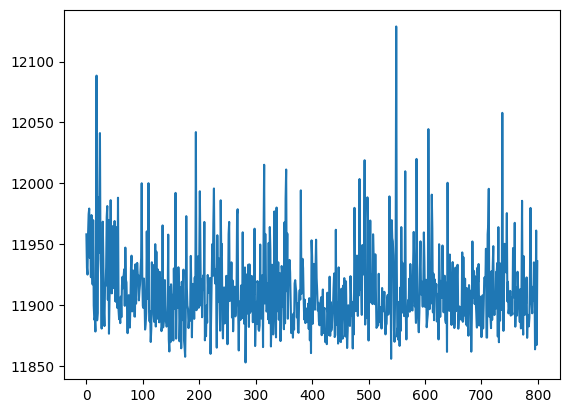

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11894.6943
[iteration 0050] loss: 11970.8545
[iteration 0100] loss: 11924.6074
[iteration 0150] loss: 11933.4814
[iteration 0200] loss: 11893.5771
[iteration 0250] loss: 11905.2070
[iteration 0300] loss: 11913.7402
[iteration 0350] loss: 11917.8174
[iteration 0400] 

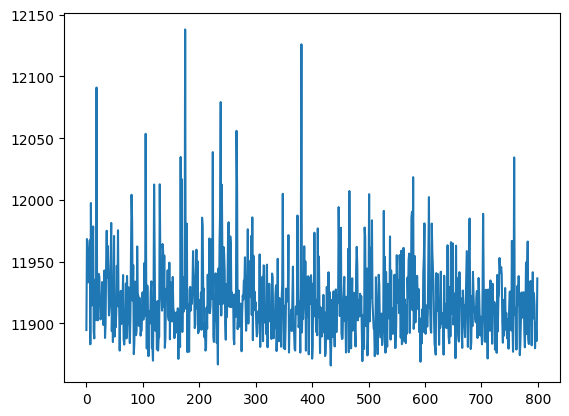

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11898.2080
[iteration 0050] loss: 11994.8945
[iteration 0100] loss: 11895.9023
[iteration 0150] loss: 11906.9326
[iteration 0200] loss: 11918.4639
[iteration 0250] loss: 11908.6104
[iteration 0300] loss

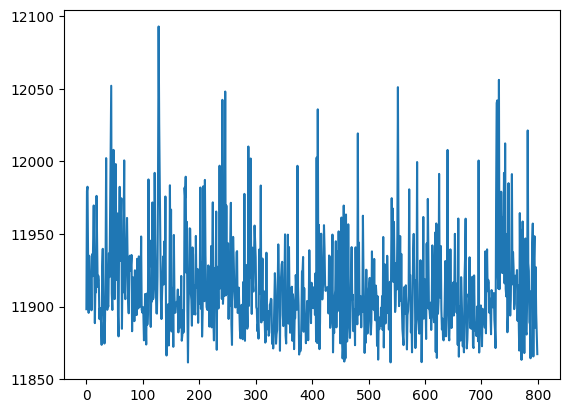

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 12039.7002
[iteration 0050] loss: 11895.7793
[iteration 0100] loss: 11906.1934
[iteration 0150] loss: 11899.6387
[iteration 0200] loss: 11

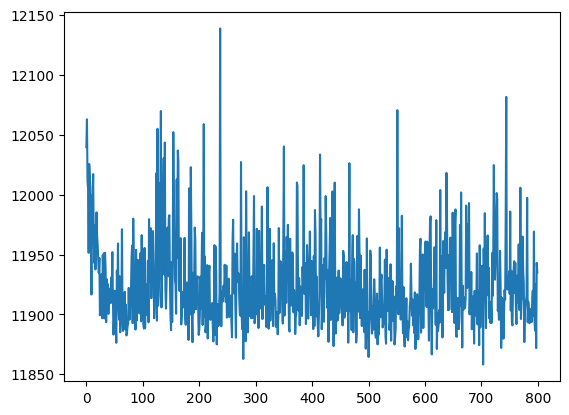

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>)}
[iteration 0001] loss: 11913.1572
[iteration 0050] loss: 11933.6865
[iteration 0100] loss: 11947.52

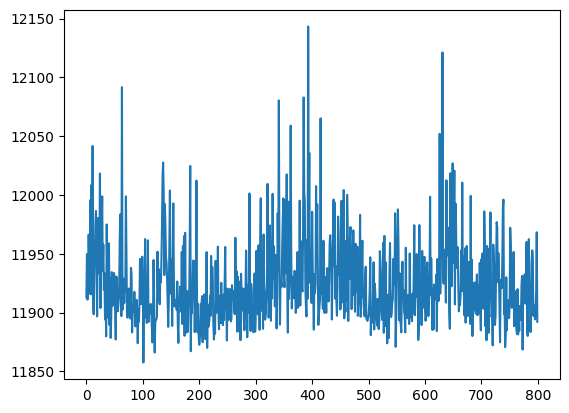

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>)}
[iteration 0001] loss:

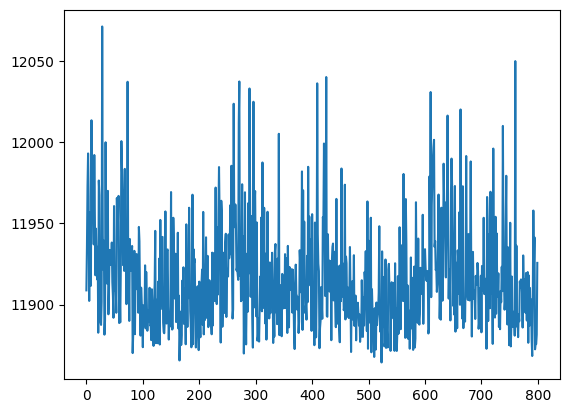

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

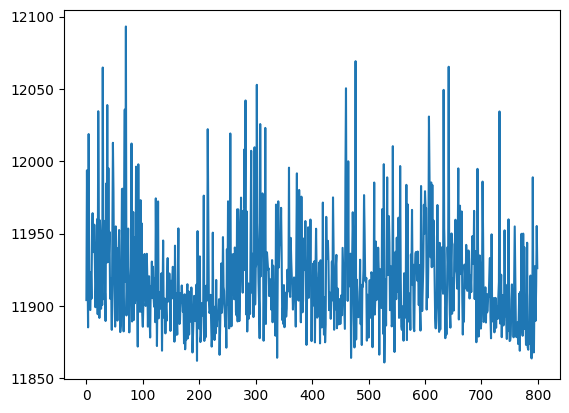

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

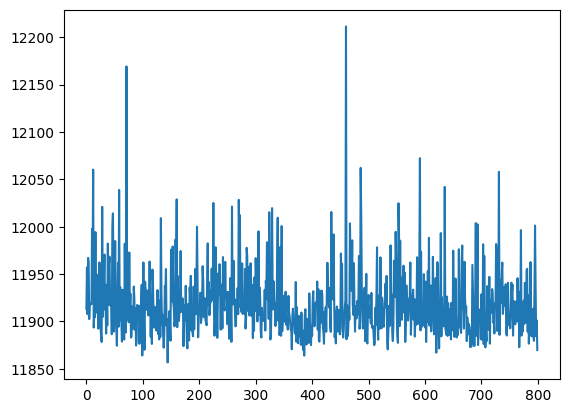

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

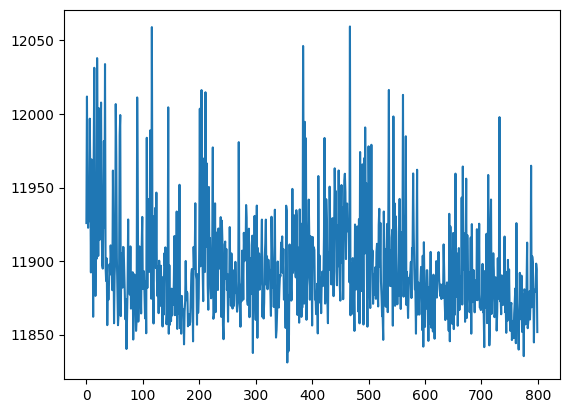

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

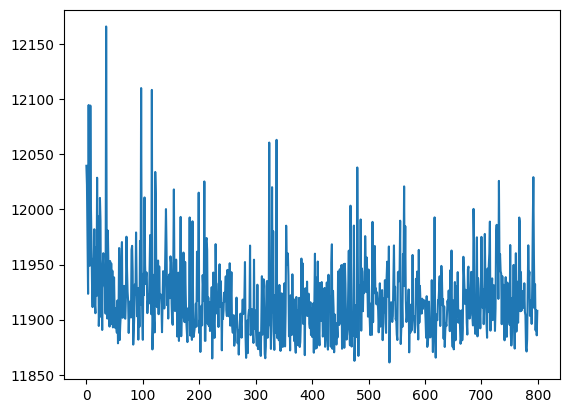

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

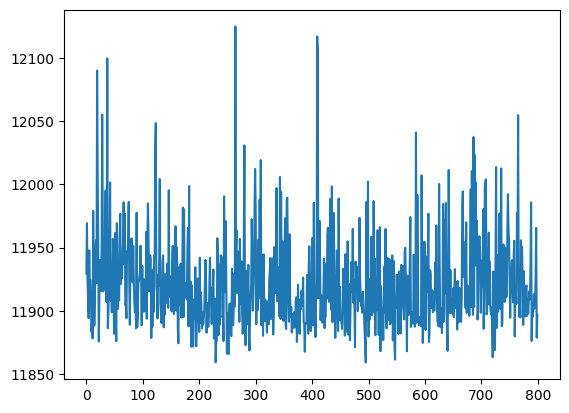

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

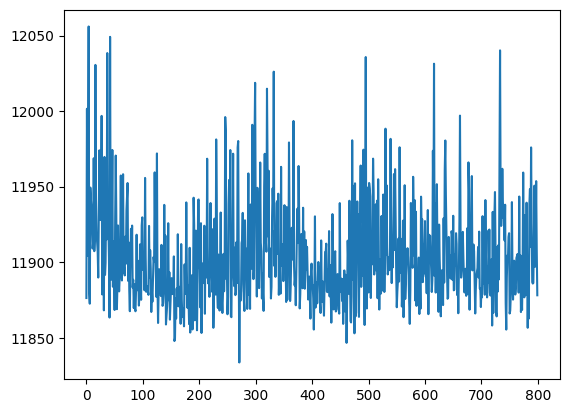

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

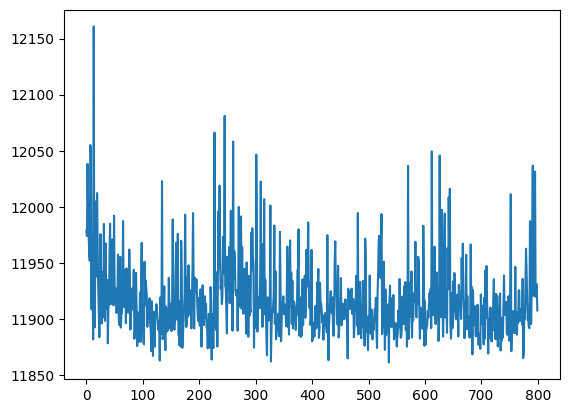

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

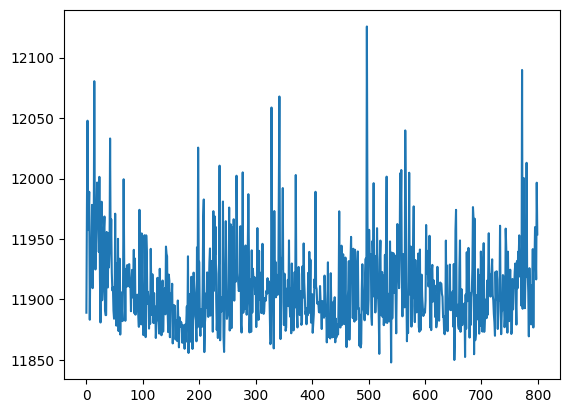

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

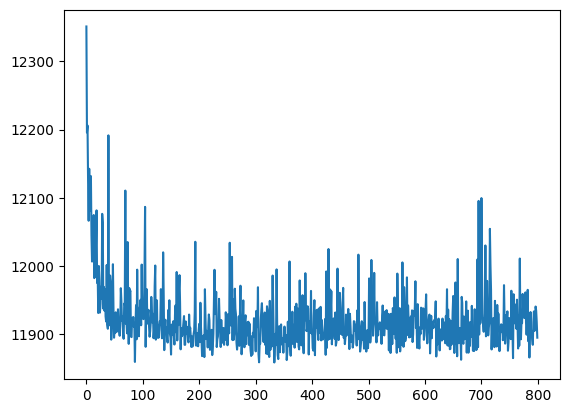

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

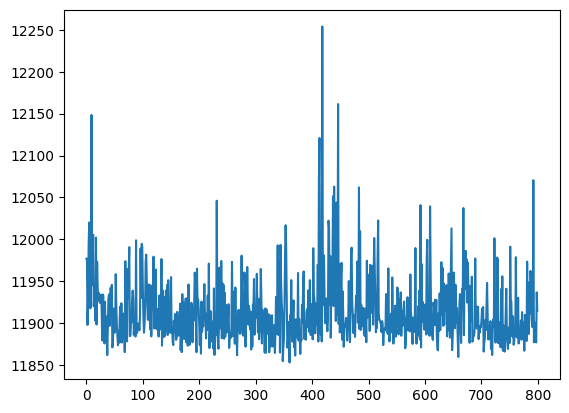

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

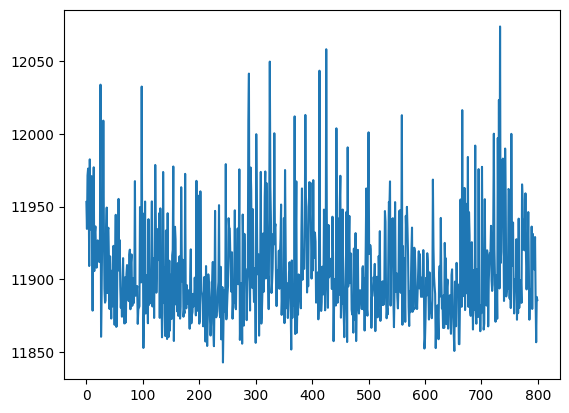

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

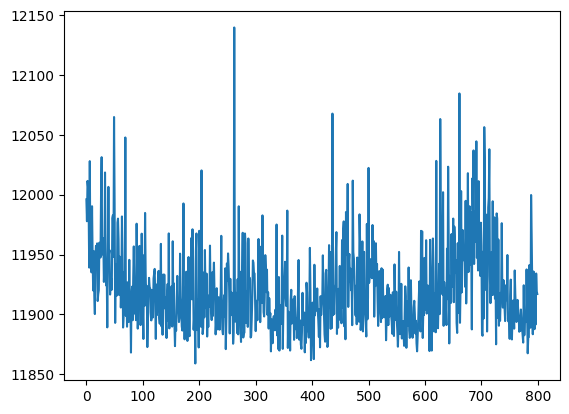

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

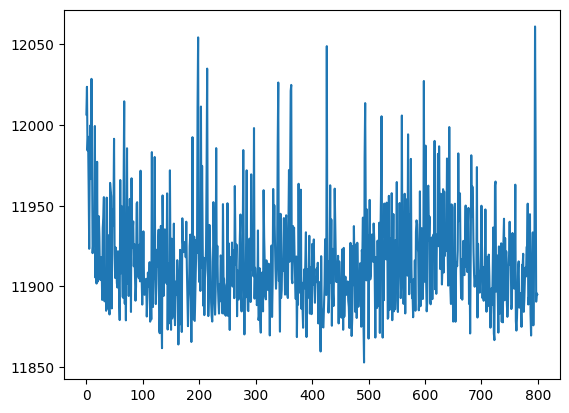

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

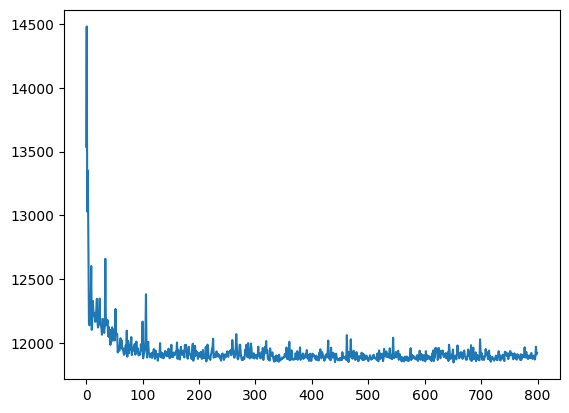

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

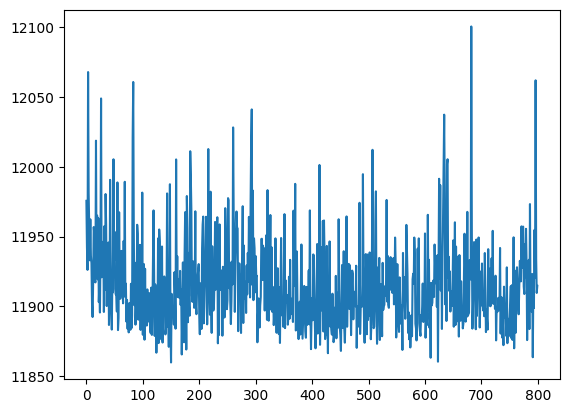

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

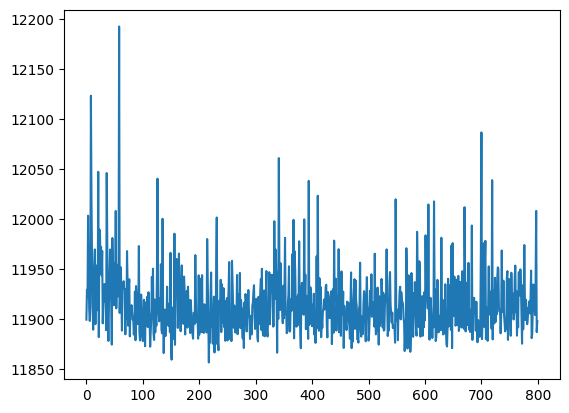

{('median_value', 'white'): tensor(2857.0957, grad_fn=<MulBackward0>), ('median_value', 'segregation'): tensor(2779.6306, grad_fn=<MulBackward0>), ('median_value', 'sqm'): tensor(2783.8835, grad_fn=<MulBackward0>), ('median_value', 'university_overlap'): tensor(2837.8850, grad_fn=<MulBackward0>), ('distance', 'median_value'): tensor(2835.8342, grad_fn=<MulBackward0>), ('distance', 'income'): tensor(2821.5127, grad_fn=<MulBackward0>), ('distance', 'white'): tensor(2842.2070, grad_fn=<MulBackward0>), ('distance', 'segregation'): tensor(2774.4124, grad_fn=<MulBackward0>), ('distance', 'sqm'): tensor(2806.7483, grad_fn=<MulBackward0>), ('income', 'median_value'): tensor(2807.5010, grad_fn=<MulBackward0>), ('income', 'white'): tensor(2794.0247, grad_fn=<MulBackward0>), ('income', 'limit'): tensor(2818.3647, grad_fn=<MulBackward0>), ('income', 'sqm'): tensor(2855.7507, grad_fn=<MulBackward0>), ('income', 'university_overlap'): tensor(2823.6135, grad_fn=<MulBackward0>), ('limit', 'median_valu

In [12]:
n_steps = 800

waic_dict = {}

for pair in living_pairs:
    interaction_set = []
    interaction_set = ins.copy()
    interaction_set.append(pair)
    
    tracts_model = TractsModelContinuousInteractions(
    **subset,
    housing_units_continuous_interaction_pairs = interaction_set
    )    

    guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset)

    waic = compute_waic(
    model=tracts_model,
    guide=guide,
    num_particles=1000,
    sites=["housing_units"],
    max_plate_nesting=9,
    **subset,
    )['waic']


    waic_dict[pair] = waic

    print(waic_dict)

    with open(f'waic_dict_{len(living_pairs)}.pkl', 'wb') as f:
        dill.dump(waic_dict, f)



In [26]:
next = {pair: waic for pair, waic in waic_dict.items() if waic < 2780}
print(len(next))

print(next.keys())



4
dict_keys([('median_value', 'segregation'), ('distance', 'segregation'), ('limit', 'sqm'), ('segregation', 'sqm')])


/home/rafal/miniconda3/envs/polis-dev/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


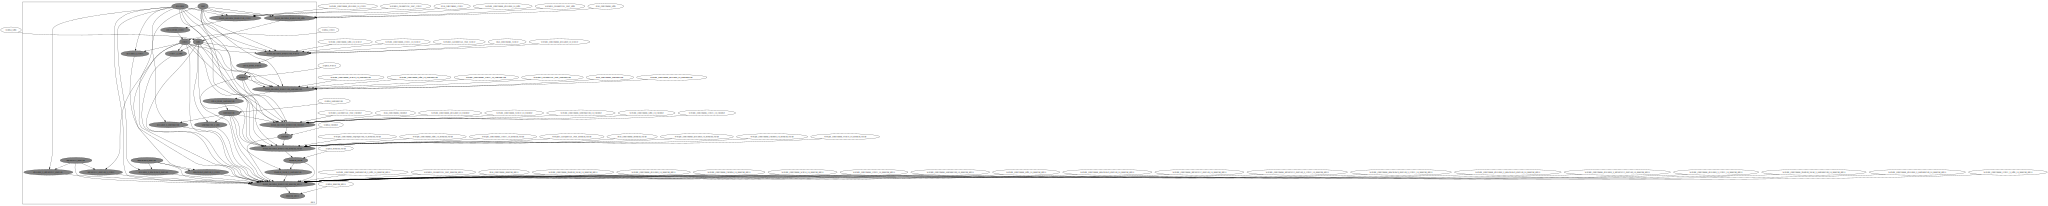

In [29]:

tracts_model = TractsModelContinuousInteractions(
    **subset,
    housing_units_continuous_interaction_pairs = ins
)

with pyro.poutine.trace() as tr:
    tracts_model(**subset)


assert tr.trace.nodes["housing_units"]["value"].shape == torch.Size([1130])

pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True,
)

/home/rafal/s78projects/cities/cities/modeling/evaluation.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  zoning_dataset_read = torch.load(data_path)


[iteration 0001] loss: 193334.5156
[iteration 0050] loss: 51043.8906
[iteration 0100] loss: 37071.8750
[iteration 0150] loss: 19508.3457
[iteration 0200] loss: 16363.8984
[iteration 0250] loss: 14211.7363
[iteration 0300] loss: 11947.3555
[iteration 0350] loss: 11257.1650
[iteration 0400] loss: 9606.6230
[iteration 0450] loss: 9054.4062
[iteration 0500] loss: 8500.4277
[iteration 0550] loss: 8819.5479
[iteration 0600] loss: 8594.3057
[iteration 0650] loss: 8213.2715
[iteration 0700] loss: 8386.7637
[iteration 0750] loss: 7945.7817
[iteration 0800] loss: 7951.6567


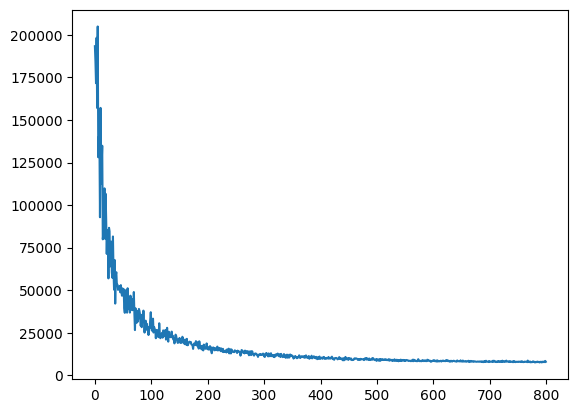

/home/rafal/s78projects/cities/cities/modeling/zoning_models/zoning_tracts_continuous_interactions_model.py:61: UserWarning: Passed categorical_levels will no longer override the levels passed to or computed during model initialization. The argument will be ignored.
  warnings.warn(


tensor(0.3669) tensor(0.4374)


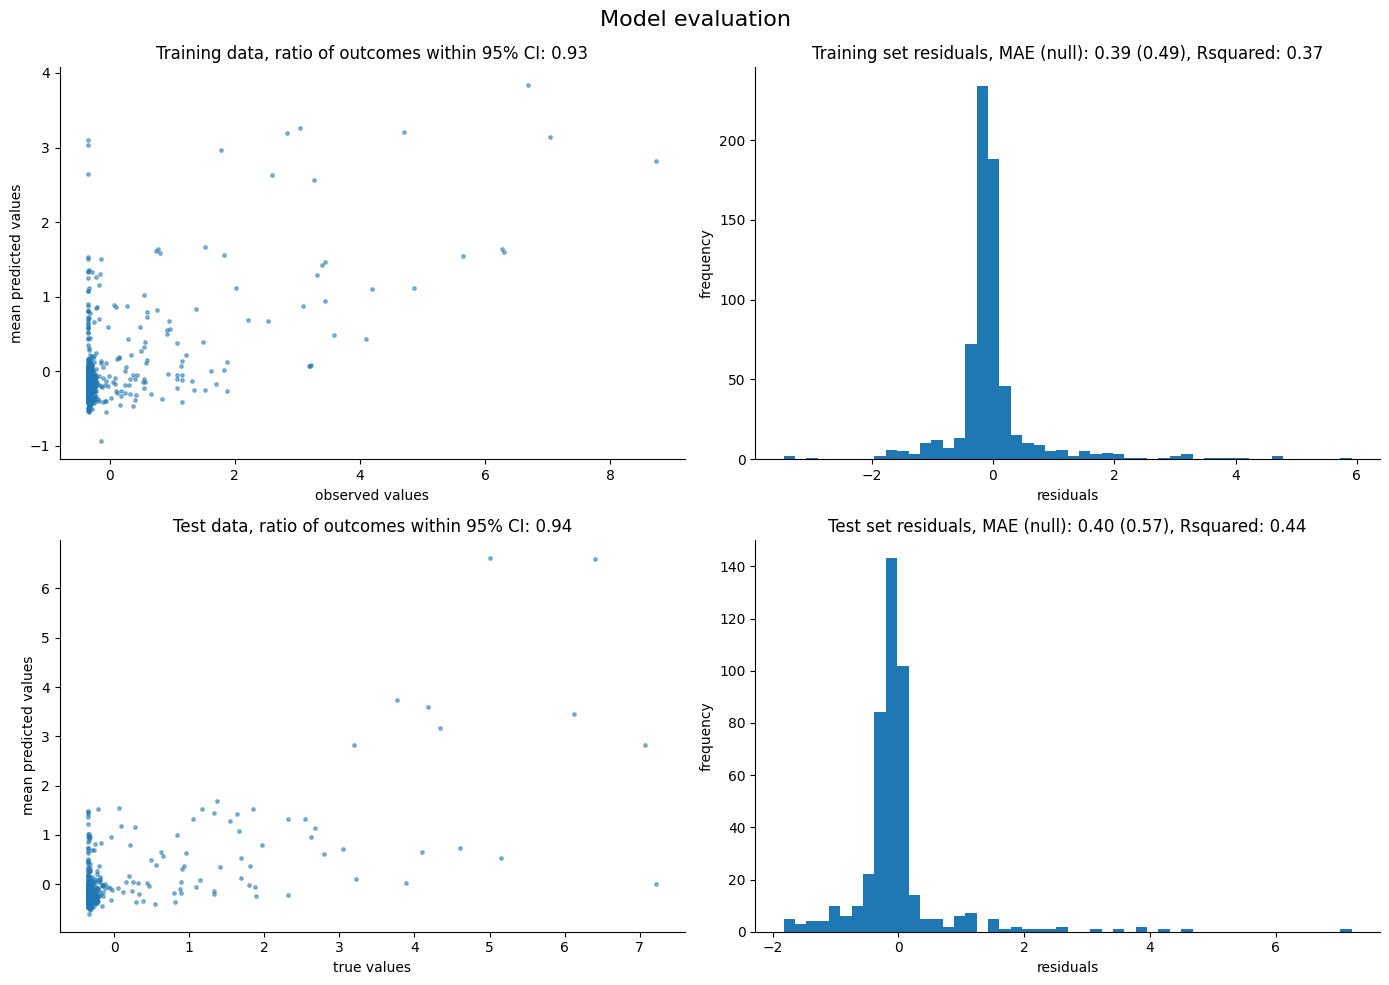

In [30]:
pyro.clear_param_store()


train_loader, test_loader, categorical_levels = prep_data_for_test(
    census_tracts_data_path, train_size=0.6
)

performance_results = test_performance(
    tracts_model,
    kwargs,
    train_loader,
    test_loader,
    categorical_levels,
    outcome_type="continuous",
    outcome_name="housing_units",
    n_steps=n_steps,
    plot=True,
    is_class=False,
)

In [31]:
def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


mae_improvement_train = destandardize_housing_units(
    performance_results["mae_null_train"] - performance_results["mae_train"]
)
mae_improvement_test = destandardize_housing_units(
    performance_results["mae_null_test"] - performance_results["mae_test"]
)

print(
    f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
)

MAE improvements on the original scale: (tensor(47.), tensor(40.))


[iteration 0001] loss: 253900.8750
[iteration 0050] loss: 30086.6504
[iteration 0100] loss: 17459.9766
[iteration 0150] loss: 14295.8896
[iteration 0200] loss: 14359.1777
[iteration 0250] loss: 13439.8105
[iteration 0300] loss: 12619.1777
[iteration 0350] loss: 12367.6045
[iteration 0400] loss: 12738.6475
[iteration 0450] loss: 12300.8057
[iteration 0500] loss: 12196.9297
[iteration 0550] loss: 12111.5645
[iteration 0600] loss: 12249.2031
[iteration 0650] loss: 12178.2783
[iteration 0700] loss: 12257.4307
[iteration 0750] loss: 12183.7578
[iteration 0800] loss: 12126.8018


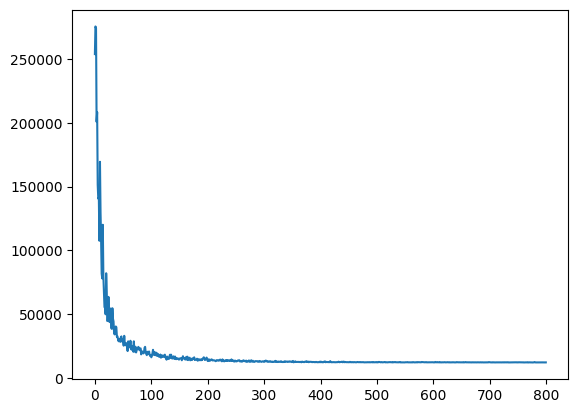

In [32]:
pyro.clear_param_store()
guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset)

#predictive = Predictive(tracts_model, guide=guide, num_samples=num_samples)

In [33]:
waic_interaction_minimal = compute_waic(
    model=tracts_model,
    guide=guide,
    num_particles=1000,
    sites=["housing_units"],
    max_plate_nesting=9,
    **subset,
)

print(waic_interaction_minimal['waic'], waic_interaction_minimal['p_waic'])

tensor(2776.8887, grad_fn=<MulBackward0>) tensor(67.3955, grad_fn=<SumBackward0>)


plain sqm has waic 2873

all pairwise interactions give waic 3705 and r2 .52 train and .22 test, overfitting

---

("university_overlap", "limit"),
        ("downtown_overlap", "limit"),
        ("median_value", "income"),
        ("distance", "downtown_overlap"),
        ("distance", "university_overlap"),
        ("distance", "limit"),
        ("income", "segregation"),

2796.3604

---

 ("university_overlap", "limit"),
            ("downtown_overlap", "limit"),
            ("distance", "downtown_overlap"),
            ("distance", "university_overlap"),
            ("distance", "limit"),

2846

---

("university_overlap", "limit"),
            ("downtown_overlap", "limit"),
            ("median_value", "income"),
            ("distance", "downtown_overlap"),
            ("distance", "university_overlap"),
            ("distance", "limit"),
            ("university_overlap", "income"),

2936

---

("university_overlap", "limit"),
            ("downtown_overlap", "limit"),
            #("median_value", "income"),
            ("distance", "downtown_overlap"),
            ("distance", "university_overlap"),

---

("university_overlap", "limit"),
("downtown_overlap", "limit"),
        ("distance", "downtown_overlap"),
("distance", "university_overlap"),

2802
---

("university_overlap", "limit"),
("downtown_overlap", "limit"),
#("median_value", "income"),
("distance", "downtown_overlap"),
("distance", "university_overlap"),
("distance", "limit"),
("sqm", "downtown_overlap")

2801
---
("university_overlap", "limit"),
("downtown_overlap", "limit"),
("distance", "downtown_overlap"),
("distance", "university_overlap"),
("distance", "limit"),
("white", "limit"),

2803

---



